<a href="https://colab.research.google.com/github/GalRabin/botnet50/blob/main/botnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bottleneck Transformers for Visual Recognition (Link to BotNet50 [Article](https://arxiv.org/pdf/2101.11605v1.pdf))

## BotNet50 implementation

### Dependencies

In [1]:
!python -V

Python 3.6.9


In [2]:
!pip freeze

absl-py==0.10.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
asgiref==3.3.1
astor==0.8.1
astropy==4.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
autograd==1.3
Babel==2.9.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.1.1
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.1
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.4
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.5
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.21
daft==0.0.4
dask==2.12.0
dataclasses==0.8
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
Django==3.1.6
dlib==19.18.0
d

In [3]:
!pip install einops

### Imports

In [4]:
import torch
from torch import nn, einsum
from torchvision import transforms, datasets
from einops import rearrange
from torchvision.models import resnet50
from google.colab import files
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from time import time

### Constants

In [5]:
BATCH_SIZE = 16
IM_SHAPE = (224, 224)
TEST_SIZE = 0.33
NUM_EPOCHS = 10
PRINT_AFTER_SAMPLE = 50
LEARNING_RATE = 0.001
MOMENTUM = 0.997
WEIGHT_DECAY = 4e-5

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Helper functions

In [7]:
def pair(x):
    return (x, x) if not isinstance(x, tuple) else x


def expand_dim(t, dim, k):
    t = t.unsqueeze(dim=dim)
    expand_shape = [-1] * len(t.shape)
    expand_shape[dim] = k
    return t.expand(*expand_shape)


def rel_to_abs(x):
    b, h, l, _, device, dtype = *x.shape, x.device, x.dtype
    dd = {'device': device, 'dtype': dtype}
    col_pad = torch.zeros((b, h, l, 1), **dd)
    x = torch.cat((x, col_pad), dim=3)
    flat_x = rearrange(x, 'b h l c -> b h (l c)')
    flat_pad = torch.zeros((b, h, l - 1), **dd)
    flat_x_padded = torch.cat((flat_x, flat_pad), dim=2)
    final_x = flat_x_padded.reshape(b, h, l + 1, 2 * l - 1)
    final_x = final_x[:, :, :l, (l - 1):]
    return final_x


def relative_logits_1d(q, rel_k):
    b, heads, h, w, dim = q.shape
    logits = einsum('b h x y d, r d -> b h x y r', q, rel_k)
    logits = rearrange(logits, 'b h x y r -> b (h x) y r')
    logits = rel_to_abs(logits)
    logits = logits.reshape(b, heads, h, w, w)
    logits = expand_dim(logits, dim=3, k=h)
    return logits


# positional embeddings

class AbsPosEmb(nn.Module):
    def __init__(
            self,
            fmap_size,
            dim_head
    ):
        super().__init__()
        height, width = pair(fmap_size)
        scale = dim_head ** -0.5
        self.height = nn.Parameter(torch.randn(height, dim_head) * scale)
        self.width = nn.Parameter(torch.randn(width, dim_head) * scale)

    def forward(self, q):
        emb = rearrange(self.height, 'h d -> h () d') + rearrange(self.width, 'w d -> () w d')
        emb = rearrange(emb, ' h w d -> (h w) d')
        logits = einsum('b h i d, j d -> b h i j', q, emb)
        return logits


class RelPosEmb(nn.Module):
    def __init__(
            self,
            fmap_size,
            dim_head
    ):
        super().__init__()
        height, width = pair(fmap_size)
        scale = dim_head ** -0.5
        self.fmap_size = fmap_size
        self.rel_height = nn.Parameter(torch.randn(height * 2 - 1, dim_head) * scale)
        self.rel_width = nn.Parameter(torch.randn(width * 2 - 1, dim_head) * scale)

    def forward(self, q):
        h, w = self.fmap_size

        q = rearrange(q, 'b h (x y) d -> b h x y d', x=h, y=w)
        rel_logits_w = relative_logits_1d(q, self.rel_width)
        rel_logits_w = rearrange(rel_logits_w, 'b h x i y j-> b h (x y) (i j)')

        q = rearrange(q, 'b h x y d -> b h y x d')
        rel_logits_h = relative_logits_1d(q, self.rel_height)
        rel_logits_h = rearrange(rel_logits_h, 'b h x i y j -> b h (y x) (j i)')
        return rel_logits_w + rel_logits_h

In [8]:
def plot_loss(train_loss):
  plt.plot(range(len(train_loss)), train_loss)
  plt.title("Train loss")
  plt.show()

### Attention

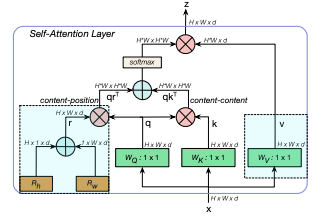

In [9]:
class Attention(nn.Module):
    def __init__(
            self,
            dim: int,
            fmap_size: int,
            heads: int = 4,
            dim_head: int = 128,
            rel_pos_emb: bool = False
    ):
        """ Attention - Multi-Head Self-Attention.

        Args:
          dim: How many pixels in the image.
          fmap_size: featuremaps size, How many featres to study?
          heads: Number of heads in MHSA.
          dim_head: Head dimention.
          rel_pos_emb: True if performing Relative position encoding else Flase.
        """
        super().__init__()
        self.heads = heads
        self.scale = dim_head ** -0.5
        inner_dim = heads * dim_head

        self.to_qkv = nn.Conv2d(dim, inner_dim * 3, 1, bias=False)

        rel_pos_class = AbsPosEmb if not rel_pos_emb else RelPosEmb
        self.pos_emb = rel_pos_class(fmap_size, dim_head)

    def forward(self, fmap):
        heads, b, c, h, w = self.heads, *fmap.shape

        q, k, v = self.to_qkv(fmap).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, 'b (h d) x y -> b h (x y) d', h=heads), (q, k, v))

        q *= self.scale

        sim = einsum('b h i d, b h j d -> b h i j', q, k)
        sim += self.pos_emb(q)

        attn = sim.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x=h, y=w)
        return out

### BottleBlock

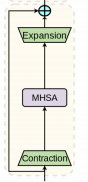
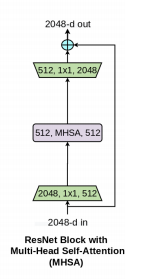

In [10]:
class BottleBlock(nn.Module):
    def __init__(
            self,
            dim: int,
            fmap_size: int,
            dim_out: int,
            downsample: bool,
            proj_factor: int = 4,
            heads: int = 4,
            dim_head: int = 128,
            rel_pos_emb: bool = False,
            activation=nn.ReLU()
    ):
        """ BottleBlock - RestNet Block with Multi-Head Self-Attention.

        Args:
          dim: How many pixels in the image.
          fmap_size: featuremaps size, How many featres to study?
          dim_out: BottleBlock out 1*dimention.
          proj_factor: Projection factor.
          downsample: True if to perform image downsample else False.
          heads: Number of heads in MHSA.
          dim_head: Head dimention.
          rel_pos_emb: True if performing Relative position encoding else Flase.
          activation: Activation function.
        """
        super().__init__()

        # shortcut - Downsample the image if needed
        if dim != dim_out or downsample:
            # If downsample -> Reduce image size with stride 2.
            # If dim != dim_out -> Some learnning with conv (Keep same size).
            kernel_size, stride, padding = (3, 2, 1) if downsample else (1, 1, 0)
            self.shortcut = nn.Sequential(
                nn.Conv2d(dim, dim_out, kernel_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(dim_out),
                activation
            )
        else:
            # dim = dimout and not downsample -> same image.
            self.shortcut = nn.Identity()

        # contraction and expansion
        attn_dim_in = dim_out // proj_factor
        attn_dim_out = heads * dim_head
        self.net = nn.Sequential(
            # Contraction
            nn.Conv2d(dim, attn_dim_in, 1, bias=False),
            nn.BatchNorm2d(attn_dim_in),
            activation,
            # MHSA
            Attention(
                dim=attn_dim_in,
                fmap_size=fmap_size,
                heads=heads,
                dim_head=dim_head,
                rel_pos_emb=rel_pos_emb
            ),
            nn.AvgPool2d((2, 2)) if downsample else nn.Identity(),
            nn.BatchNorm2d(attn_dim_out),
            activation,
            # Expansion
            nn.Conv2d(attn_dim_out, dim_out, 1, bias=False),
            nn.BatchNorm2d(dim_out)
        )
        # Init last batch norm gamma to zero
        nn.init.zeros_(self.net[-1].weight)
        # Final activation
        self.activation = activation

    def forward(self, x):
        # Moving in the shortcut path to the end
        shortcut = self.shortcut(x)
        # Forward threw the net.
        x = self.net(x)
        # Adding the shortcut
        x += shortcut
        # Perform activation
        return self.activation(x)

### BottleNeck Transformer

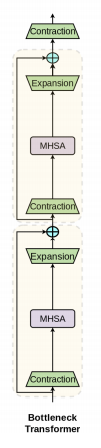

In [11]:
class BottleNeck(nn.Module):
    def __init__(
            self,
            dim: int,
            fmap_size: int,
            dim_out: int = 2048,
            proj_factor: int = 4,
            num_layers: int = 3,
            heads: int = 4,
            dim_head: int = 128,
            downsample: bool = True,
            rel_pos_emb: bool = False,
            activation=nn.ReLU()
    ):
        """ BottleNeck transformer.

        Args:
          dim: How many pixels in the image.
          fmap_size: featuremaps size, How many featres to study?
          dim_out: BottleBlock out 1*dimention.
          proj_factor: Projection factor.
          num_layers: Number of BottleBlocks.
          downsample: True if to perform image downsample else False.
          heads: Number of heads in MHSA.
          dim_head: Head dimention.
          rel_pos_emb: True if performing Relative position encoding else Flase.
          activation: Activation function.
        """
        super().__init__()
        self.dim = dim
        self.fmap_size = pair(fmap_size)
        layers = []
        for i in range(num_layers):
            is_first = i == 0
            dim = (dim if is_first else dim_out)
            layer_downsample = is_first and downsample
            fmap_divisor = (2 if downsample and not is_first else 1)
            layer_fmap_size = tuple(map(lambda t: t // fmap_divisor, self.fmap_size))

            layers.append(BottleBlock(
                dim=dim,
                fmap_size=layer_fmap_size,
                dim_out=dim_out,
                proj_factor=proj_factor,
                heads=heads,
                dim_head=dim_head,
                downsample=layer_downsample,
                rel_pos_emb=rel_pos_emb,
                activation=activation
            ))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        _, c, h, w = x.shape
        assert c == self.dim, f'channels of feature map {c} must match channels given at init {self.dim}'
        assert h == self.fmap_size[0] and w == self.fmap_size[
            1], f'height and width ({h} {w}) of feature map must match the fmap_size given at init {self.fmap_size}'
        return self.net(x)

### BotNet50

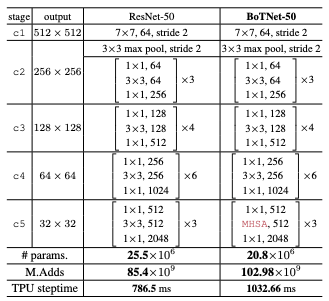

In [12]:
class BotNet50(nn.Module):
    def __init__(self,
          dim: int = 1024, #256,
          fmap_size: int = 14, #56,
          dim_out: int = 2048,
          proj_factor: int = 4,
          num_layers: int = 3,
          heads: int = 4,
          dim_head: int = 128,
          downsample: bool = True,
          rel_pos_emb: bool = False,
          activation=nn.ReLU()):
        """ BotNet50.

          Args:
            dim: How many pixels in the image.
            fmap_size: featuremaps size, How many featres to study?
            dim_out: BottleBlock out 1*dimention.
            proj_factor: Projection factor.
            num_layers: Number of BottleBlocks.
            downsample: True if to perform image downsample else False.
            heads: Number of heads in MHSA.
            dim_head: Head dimention.
            rel_pos_emb: True if performing Relative position encoding else Flase.
            activation: Activation function.
        """
        super(BotNet50, self).__init__()
        layer = BottleNeck(
            dim=dim,
            fmap_size=fmap_size,
            dim_out=dim_out,
            proj_factor=proj_factor,
            downsample=downsample,
            heads=heads,
            dim_head=dim_head,
            rel_pos_emb=rel_pos_emb,
            activation=activation
        )

        resnet = resnet50()

        # model surgery

        backbone = list(resnet.children())

        self._model = nn.Sequential(
            *backbone[:7],
            layer,
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(1),
            nn.Linear(2048, 2)
        )

    def forward(self, x):
        return self._model(x)

## BotNet50 train

### Data load

In [13]:
!git clone https://github.com/GalRabin/botnet50.git

Cloning into 'botnet50'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 5981 (delta 17), reused 0 (delta 0), pack-reused 5951
Receiving objects: 100% (5981/5981), 303.00 MiB | 46.46 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Checking out files: 100% (6004/6004), done.


In [14]:
data_transform = transforms.Compose([
        transforms.Resize(IM_SHAPE),
        transforms.ToTensor(),
    ])
guns_dataset = datasets.ImageFolder(root='/content/botnet50/gun-data',
                                           transform=data_transform)
X = [im[0] for im in guns_dataset]
y = guns_dataset.targets
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=TEST_SIZE,
                                                  stratify=y)

train_dataset = list(zip(X_train, y_train))
trainloader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=BATCH_SIZE, 
                                             shuffle=True)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


### Train

In [15]:
def train(net, optimizer):
  start_time = time()
  train_loss = []
  for epoch in range(NUM_EPOCHS):  
    cur_train_loss = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        cur_train_loss += loss.item()
        if (i+1) % PRINT_AFTER_SAMPLE == 0:    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, cur_train_loss / (i+1)))
    train_loss.append(cur_train_loss / (i+1))
  return train_loss, time()-start_time

In [16]:
net = BotNet50().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
train_loss, train_time = train(net, optimizer)

[1,    50] loss: 0.609
[1,   100] loss: 0.568
[1,   150] loss: 0.561
[1,   200] loss: 0.589
[1,   250] loss: 0.582
[2,    50] loss: 0.514
[2,   100] loss: 0.479
[2,   150] loss: 0.494
[2,   200] loss: 0.478
[2,   250] loss: 0.478
[3,    50] loss: 0.408
[3,   100] loss: 0.405
[3,   150] loss: 0.429
[3,   200] loss: 0.439
[3,   250] loss: 0.441
[4,    50] loss: 0.397
[4,   100] loss: 0.412
[4,   150] loss: 0.393
[4,   200] loss: 0.378
[4,   250] loss: 0.375
[5,    50] loss: 0.327
[5,   100] loss: 0.348
[5,   150] loss: 0.338
[5,   200] loss: 0.335
[5,   250] loss: 0.355
[6,    50] loss: 0.370
[6,   100] loss: 0.352
[6,   150] loss: 0.347
[6,   200] loss: 0.344
[6,   250] loss: 0.346
[7,    50] loss: 0.316
[7,   100] loss: 0.323
[7,   150] loss: 0.324
[7,   200] loss: 0.325
[7,   250] loss: 0.315
[8,    50] loss: 0.334
[8,   100] loss: 0.304
[8,   150] loss: 0.299
[8,   200] loss: 0.306
[8,   250] loss: 0.304
[9,    50] loss: 0.254
[9,   100] loss: 0.260
[9,   150] loss: 0.264
[9,   200] 

In [17]:
train_time

558.3639974594116

In [18]:
baseline = resnet50().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(baseline.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
baseline_train_loss, baseline_train_time = train(baseline, optimizer)

[1,    50] loss: 1.206
[1,   100] loss: 1.625
[1,   150] loss: 1.665
[1,   200] loss: 1.519
[1,   250] loss: 1.374
[2,    50] loss: 1.020
[2,   100] loss: 1.011
[2,   150] loss: 1.291
[2,   200] loss: 1.168
[2,   250] loss: 1.086
[3,    50] loss: 0.729
[3,   100] loss: 0.735
[3,   150] loss: 0.823
[3,   200] loss: 0.818
[3,   250] loss: 0.798
[4,    50] loss: 1.472
[4,   100] loss: 0.986
[4,   150] loss: 0.930
[4,   200] loss: 0.886
[4,   250] loss: 0.895
[5,    50] loss: 1.967
[5,   100] loss: 1.271
[5,   150] loss: 1.075
[5,   200] loss: 1.026
[5,   250] loss: 0.934
[6,    50] loss: 0.576
[6,   100] loss: 0.593
[6,   150] loss: 0.618
[6,   200] loss: 0.600
[6,   250] loss: 0.587
[7,    50] loss: 0.530
[7,   100] loss: 0.476
[7,   150] loss: 0.463
[7,   200] loss: 0.455
[7,   250] loss: 0.445
[8,    50] loss: 0.449
[8,   100] loss: 0.431
[8,   150] loss: 0.430
[8,   200] loss: 0.422
[8,   250] loss: 0.411
[9,    50] loss: 0.398
[9,   100] loss: 0.436
[9,   150] loss: 0.419
[9,   200] 

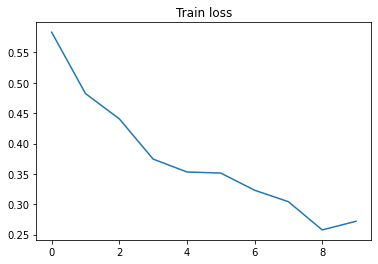

In [19]:
plot_loss(train_loss)

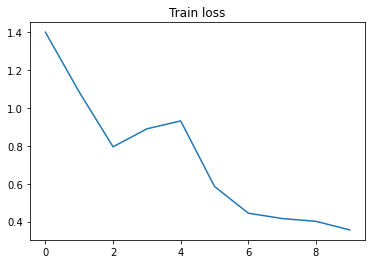

In [20]:
plot_loss(baseline_train_loss)

## BotNet50 test

### Data load

In [21]:
test_dataset = list(zip(X_val, y_val))
testloader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE, 
                                             shuffle=False)

### Evaluation

In [22]:
def eval_model(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          inputs, labels = data
          inputs = inputs.to(DEVICE)
          labels = labels.to(DEVICE)
          outputs = net(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

In [23]:
print("Resnet50's accuracy: ")
eval_model(baseline)
print("BoTNet50's accuracy: ")
eval_model(net)

Resnet50's accuracy: 
Accuracy of the network on the test images: 84 %
BoTNet50's accuracy: 
Accuracy of the network on the test images: 89 %
